# Customer Churn Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

## Exploration

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


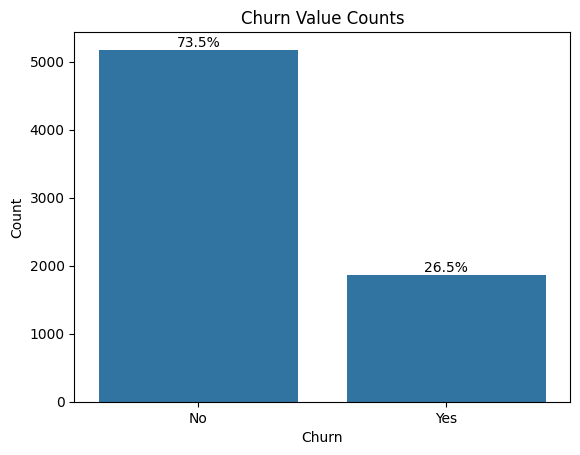

In [3]:
ax = sns.barplot(x=df['Churn'].value_counts().index, y=df['Churn'].value_counts().values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Value Counts')

total = df.shape[0]
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

## Data Preprcoessing

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df = df[~df['Churn'].isna()]

binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'Churn']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df = pd.get_dummies(df, drop_first=True)

## Train Test Split

In [5]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

## Model Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1036
           1       0.69      0.45      0.54       373

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



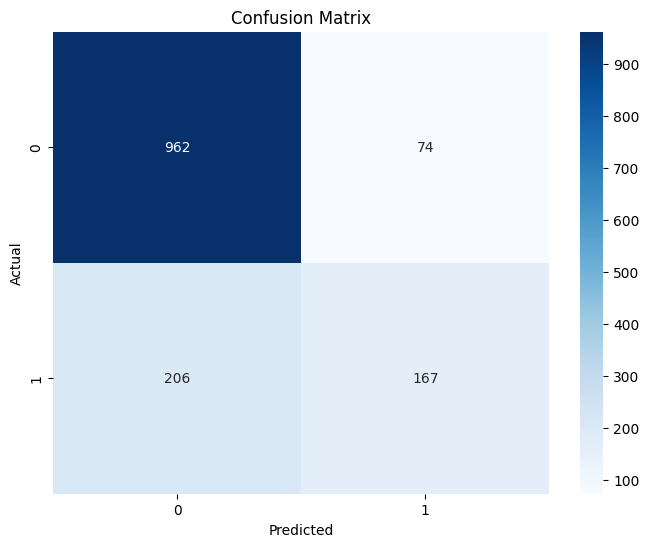

ROC AUC: {auc:.4f}



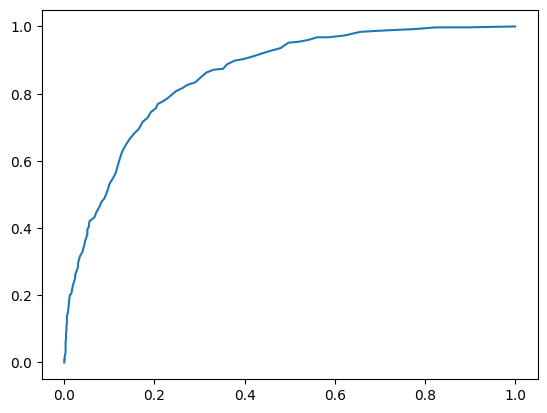

In [8]:
plt.figure(figsize=(8, 6))

print("Classification Report:\n", classification_report(y_test, rf_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC AUC Score
auc = roc_auc_score(y_test, rf_probs)
print("ROC AUC: {auc:.4f}\n")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label='(AUC = {auc:.2f})')

## Prediction

In [ ]:
multi_customers = X.iloc[:10].copy()
multi_customers['MonthlyCharges'] = [50, 70, 90, 110, 130, 110, 80, 60, 100, 120]
multi_customers['tenure'] = [12, 2, 1, 10, 5, 8, 3, 4, 6, 9]

scaled_multi = scaler.transform(multi_customers)
predictions = rf_model.predict(scaled_multi).flatten()

for i, prob in enumerate(predictions):
    print(f"Customer {i+1}: Churn Probability = {prob:.2%}, Predicted Class = {'Churn' if prob > 0.5 else 'No Churn'}")

Customer 1: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 2: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 3: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 4: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 5: Churn Probability = 100.00%, Predicted Class = Churn
